In [1]:
import time
import os

os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import pytorch3d.ops
from plyfile import PlyData, PlyElement
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image
from argparse import ArgumentParser, Namespace
import cv2

from arguments import ModelParams, PipelineParams
from scene import Scene, GaussianModel, FeatureGaussianModel
from gaussian_renderer import render, render_contrastive_feature


from utils.sh_utils import SH2RGB

def get_combined_args(parser : ArgumentParser, model_path, target_cfg_file = None):
    cmdlne_string = ['--model_path', model_path]
    cfgfile_string = "Namespace()"
    args_cmdline = parser.parse_args(cmdlne_string)
    
    if target_cfg_file is None:
        if args_cmdline.target == 'seg':
            target_cfg_file = "seg_cfg_args"
        elif args_cmdline.target == 'scene' or args_cmdline.target == 'xyz':
            target_cfg_file = "cfg_args"
        elif args_cmdline.target == 'feature' or args_cmdline.target == 'coarse_seg_everything' or args_cmdline.target == 'contrastive_feature' :
            target_cfg_file = "feature_cfg_args"

    try:
        cfgfilepath = os.path.join(model_path, target_cfg_file)
        print("Looking for config file in", cfgfilepath)
        with open(cfgfilepath) as cfg_file:
            print("Config file found: {}".format(cfgfilepath))
            cfgfile_string = cfg_file.read()
    except TypeError:
        print("Config file found: {}".format(cfgfilepath))
        pass
    args_cfgfile = eval(cfgfile_string)

    merged_dict = vars(args_cfgfile).copy()
    for k,v in vars(args_cmdline).items():
        if v != None:
            merged_dict[k] = v

    return Namespace(**merged_dict)

# Hyper-parameters

In [2]:
import os
FEATURE_DIM = 32 # fixed

# MODEL_PATH = './output/lerf-fruit_aisle/'
MODEL_PATH = './output/lund_1024' # 30000

FEATURE_GAUSSIAN_ITERATION = 10000

SCALE_GATE_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scale_gate.pt')

FEATURE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/contrastive_feature_point_cloud.ply')
SCENE_PCD_PATH = os.path.join(MODEL_PATH, f'point_cloud/iteration_{str(FEATURE_GAUSSIAN_ITERATION)}/scene_point_cloud.ply')

# Data and Model Preparation


In [3]:
scale_gate = torch.nn.Sequential(
    torch.nn.Linear(1, 32, bias=True),
    torch.nn.Sigmoid()
)

scale_gate.load_state_dict(torch.load(SCALE_GATE_PATH))
scale_gate = scale_gate.cuda()

parser = ArgumentParser(description="Testing script parameters")
model = ModelParams(parser, sentinel=True)
pipeline = PipelineParams(parser)
parser.add_argument('--target', default='scene', type=str)

args = get_combined_args(parser, MODEL_PATH)

dataset = model.extract(args)

# If use language-driven segmentation, load clip feature and original masks
dataset.need_features = True

# To obtain mask scales
dataset.need_masks = True

scene_gaussians = GaussianModel(dataset.sh_degree)

feature_gaussians = FeatureGaussianModel(FEATURE_DIM)
scene = Scene(dataset, scene_gaussians, feature_gaussians, load_iteration=-1, feature_load_iteration=FEATURE_GAUSSIAN_ITERATION, shuffle=False, mode='eval', target='contrastive_feature')


Looking for config file in ./output/lund_1024/cfg_args
Config file found: ./output/lund_1024/cfg_args
Loading trained model at iteration 30000, 10000
Allow Camera Principle Point Shift: False
Reading camera 1196/1196
✅ Loaded 1196 cameras for this GPU (start_idx=0, end_idx=None)
Loading Training Cameras
Loading Test Cameras


In [4]:
from sklearn.preprocessing import QuantileTransformer
# Borrowed from GARField, but modified
def get_quantile_func(scales: torch.Tensor, distribution="normal"):
    """
    Use 3D scale statistics to normalize scales -- use quantile transformer.
    """
    scales = scales.flatten()

    scales = scales.detach().cpu().numpy()
    print(scales.max(), '?')

    # Calculate quantile transformer
    quantile_transformer = QuantileTransformer(output_distribution=distribution)
    quantile_transformer = quantile_transformer.fit(scales.reshape(-1, 1))

    
    def quantile_transformer_func(scales):
        scales_shape = scales.shape

        scales = scales.reshape(-1,1)
        
        return torch.Tensor(
            quantile_transformer.transform(scales.detach().cpu().numpy())
        ).to(scales.device).reshape(scales_shape)

    return quantile_transformer_func, quantile_transformer
    
all_scales = []
for cam in scene.getTrainCameras():
    scale_path = os.path.join(dataset.source_path, 'mask_scales', cam.image_name + '.pt')
    scales = torch.load(scale_path)
    all_scales.append(scales)

all_scales = torch.cat(all_scales)

upper_bound_scale = all_scales.max().item()
# upper_bound_scale = np.percentile(all_scales.detach().cpu().numpy(), 75)

# all_scales = []
# for cam in scene.getTrainCameras():
#     cam.mask_scales = torch.clamp(cam.mask_scales, 0, upper_bound_scale).detach()
#     all_scales.append(cam.mask_scales)
# all_scales = torch.cat(all_scales)

# quantile transformer
q_trans, q_trans_ = get_quantile_func(all_scales, 'uniform')

18.245272 ?


In [5]:
all_scales.max()

tensor(18.2453, grad_fn=<MaxBackward1>)

In [6]:
# For saving the normal q_trans, if the q_trans is uniform, we don't have to save it

# from joblib import dump, load
# dump(q_trans_, 'quantile_trans_test.jl')
# a = load('quantile_trans_test.jl')

In [7]:
upper_bound_scale

18.245271682739258

In [8]:
q_trans(torch.Tensor([70]))

tensor([1.])

# Begin Segmenting

In [9]:
from copy import deepcopy
cameras = scene.getTrainCameras()
print("There are",len(cameras),"views in the dataset.")
print(upper_bound_scale)

There are 1196 views in the dataset.
18.245271682739258


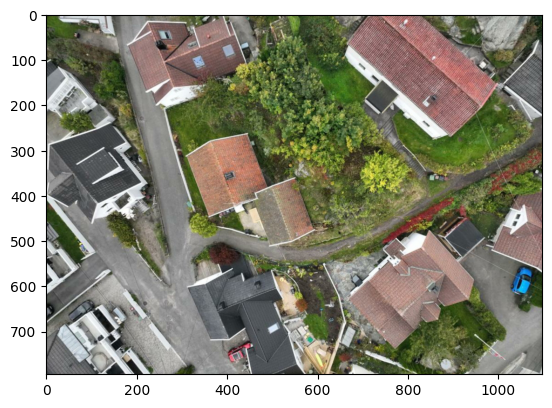

In [10]:
ref_img_camera_id = 17
mask_img_camera_id = 0

view = deepcopy(cameras[ref_img_camera_id])

view.feature_height, view.feature_width = view.image_height, view.image_width
img = view.original_image * 255
img = img.permute([1,2,0]).detach().cpu().numpy().astype(np.uint8)

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_feature = render_contrastive_feature(view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True, smooth_type = None)['render']
feature_h, feature_w = rendered_feature.shape[-2:]


plt.imshow(img)

# Point Prompt

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.29415864..0.44591436].


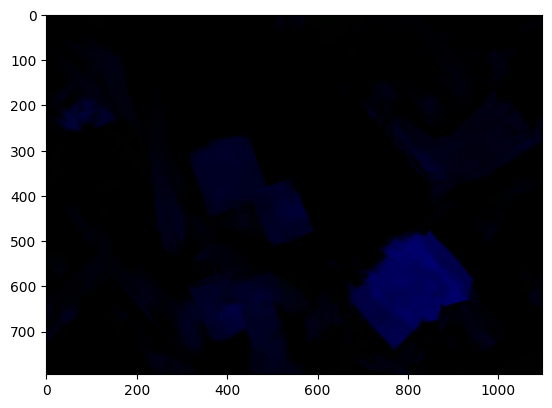

In [11]:
with torch.no_grad():
    # If the q_trans is normal
    # scale = 2.
    # scale = torch.full((1,), scale).cuda()
    # scale = q_trans(scale)

    # If the q_trans is uniform, the scale can be any value between 0 and 1
    # scale = torch.tensor([0]).cuda()
    # scale = torch.tensor([0.5]).cuda()
    scale = torch.tensor([1.5]).cuda()

    gates = scale_gate(scale)

    feature_with_scale = rendered_feature
    feature_with_scale = feature_with_scale * gates.unsqueeze(-1).unsqueeze(-1)
    scale_conditioned_feature = feature_with_scale.permute([1,2,0])

    plt.imshow(scale_conditioned_feature[:,:,:3].detach().cpu().numpy())

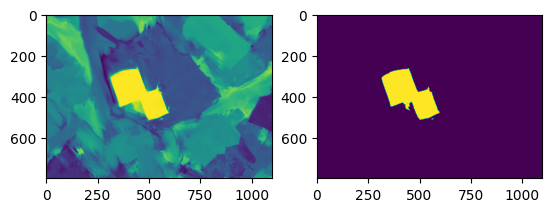

In [12]:
query_index = (300, 400)

query_index = (
    int(query_index[0] / view.image_height * view.feature_height),
    int(query_index[1] / view.image_width * view.feature_width),
               )

normed_features = torch.nn.functional.normalize(scale_conditioned_feature, dim = -1, p = 2)
query_feature = normed_features[query_index[0], query_index[1]]

similarity = torch.einsum('C,HWC->HW', query_feature, normed_features)

plt.subplot(1,2,1)
plt.imshow(similarity.detach().cpu().numpy())
plt.subplot(1,2,2)
plt.imshow(similarity.detach().cpu().numpy() > 0.75)

In [13]:
# SHOW PCA in 2D

# # CHW -> PCA dimension reduction DHW (D=3)

# from sklearn.decomposition import PCA

# pca = PCA(n_components=3)


# # t = pca.fit_transform(torch.nn.functional.normalize(rendered_feature, dim = 0).reshape(rendered_feature.shape[0], -1).permute([1,0]).cpu().detach().numpy())
# t = pca.fit_transform(normed_features.reshape(-1, normed_features.shape[-1]).cpu().detach().numpy())

# t = (t - t.min(axis=0)) / (t.max(axis=0)-t.min(axis=0))
# t = t.reshape(normed_features.shape[0], normed_features.shape[1], 3)
# plt.imshow(t)

# Cluster in 2D

In [14]:
downsampled_features = torch.nn.functional.interpolate(scale_conditioned_feature.permute([2,0,1]).unsqueeze(0), (256, 256), mode = 'bilinear').squeeze()
cluster_normed_features = torch.nn.functional.normalize(downsampled_features, dim = 0, p = 2).permute([1,2,0])

In [15]:
import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=80, cluster_selection_epsilon=0.01)
cluster_labels = clusterer.fit_predict(cluster_normed_features.reshape([-1, cluster_normed_features.shape[-1]]).detach().cpu().numpy())
labels = cluster_labels.reshape([cluster_normed_features.shape[0], cluster_normed_features.shape[1]])
print(np.unique(labels))

cluster_centers = torch.zeros(len(np.unique(labels))-1, cluster_normed_features.shape[-1])
for i in range(1, len(np.unique(labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(cluster_normed_features[labels == i-1].mean(dim = 0), dim = -1)

label_to_color = np.random.rand(200, 3)

/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/home/niranjanar/miniconda3/envs/new_env/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46
 47 48 49 50 51 52 53 54 55 56]


In [16]:

label_to_color = np.random.rand(200, 3)
segmentation_res = torch.einsum('nc,hwc->hwn', cluster_centers.cuda(), normed_features)

segmentation_res_idx = segmentation_res.argmax(dim = -1)
colored_labels = label_to_color[segmentation_res_idx.cpu().numpy().astype(np.int8)]

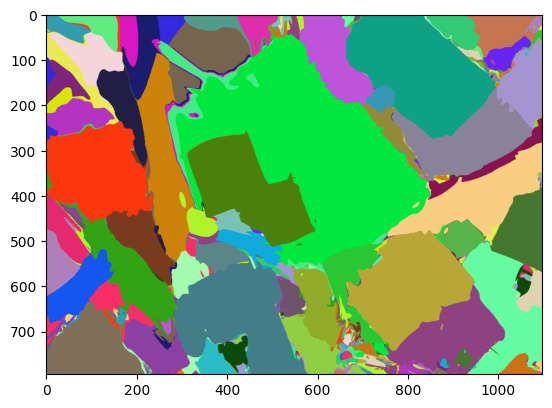

In [17]:
plt.imshow(colored_labels)

# Segmentation in 3D

After obtaining query features, we can use it to segment objects in 3D.

In [18]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = point_features * gates.unsqueeze(0)


In [19]:
normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

similarities = torch.einsum('C,NC->N', query_feature.cuda(), normed_scale_conditioned_point_features)

similarities[similarities < 0.3] = 0

In [20]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_similarities = render(cameras[17], scene_gaussians, pipeline.extract(args), background, override_color=similarities.unsqueeze(-1).repeat([1,3]))['render']

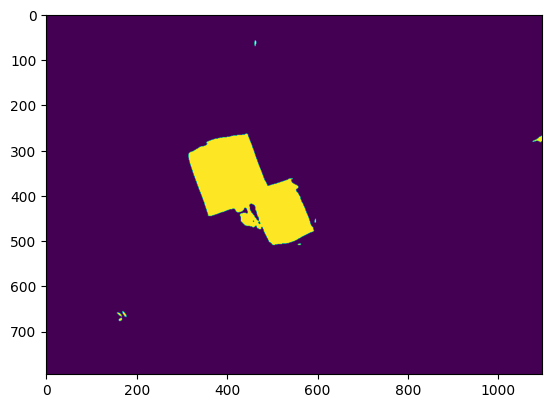

In [21]:
plt.imshow(rendered_similarities.permute([1,2,0])[:,:,0].detach().cpu() > 0.6)

In [22]:
'''try:
    scene_gaussians.roll_back()
except:
    pass'''
scene_gaussians.segment(similarities > 0.48)

In [23]:
# save the segmentation
name = 'precomputed_mask'
import os
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(similarities > 0.48, f'./segmentation_res/{name}.pt')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00061200873..1.4891292].


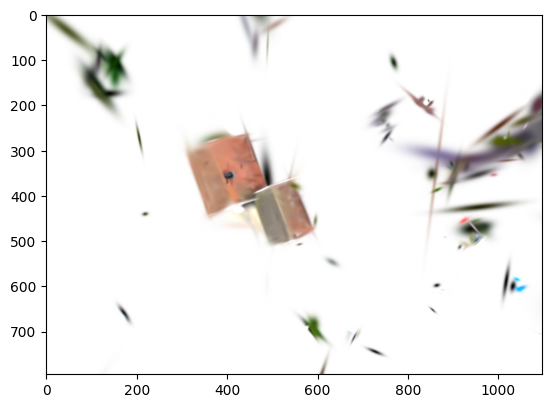

In [24]:
bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())

In [25]:
scene_gaussians.roll_back()

# Cluster in 3D

In [26]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)
#niranjana
rand_mask = torch.rand(scale_conditioned_point_features.shape[0]) > 0.98
sampled_indices = rand_mask.nonzero(as_tuple=True)[0]

sampled_point_features = scale_conditioned_point_features[sampled_indices]
normed_sampled_point_features = torch.nn.functional.normalize(sampled_point_features, dim=-1)
#niranjana
#sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

#normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

20319


In [27]:
point_features = feature_gaussians.get_point_features

scale_conditioned_point_features = torch.nn.functional.normalize(point_features, dim = -1, p = 2) * gates.unsqueeze(0)

normed_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)
#niranjana
rand_mask = torch.rand(scale_conditioned_point_features.shape[0]) > 0.98
sampled_indices = rand_mask.nonzero(as_tuple=True)[0]

sampled_point_features = scale_conditioned_point_features[sampled_indices]
normed_sampled_point_features = torch.nn.functional.normalize(sampled_point_features, dim=-1)
#niranjana
#sampled_point_features = scale_conditioned_point_features[torch.rand(scale_conditioned_point_features.shape[0]) > 0.98]

#normed_sampled_point_features = sampled_point_features / torch.norm(sampled_point_features, dim = -1, keepdim = True)

print(len(sampled_point_features))

20226


In [28]:
'''import hdbscan

clusterer = hdbscan.HDBSCAN(min_cluster_size=120, cluster_selection_epsilon=0.08)

cluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())
print(np.unique(cluster_labels))

cluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])
for i in range(1, len(np.unique(cluster_labels))):
    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)'''

'import hdbscan\n\nclusterer = hdbscan.HDBSCAN(min_cluster_size=120, cluster_selection_epsilon=0.08)\n\ncluster_labels = clusterer.fit_predict(normed_sampled_point_features.detach().cpu().numpy())\nprint(np.unique(cluster_labels))\n\ncluster_centers = torch.zeros(len(np.unique(cluster_labels))-1, normed_sampled_point_features.shape[-1])\nfor i in range(1, len(np.unique(cluster_labels))):\n    cluster_centers[i-1] = torch.nn.functional.normalize(normed_sampled_point_features[cluster_labels == i-1].mean(dim = 0), dim = -1)'

In [29]:
from sklearn.cluster import KMeans
import numpy as np
import matplotlib.pyplot as plt
xyz_positions = scene.feature_gaussians.get_xyz
concat = torch.cat([normed_point_features, 0.3 * xyz_positions], dim=1)
# Step 1: Use all contrastive features (no sampling!)
#all_features = normed_point_features  # shape [N, D]

# Step 2: KMeans clustering
k = 30  # adjust as needed
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(concat.detach().cpu().numpy())

print(f"KMeans assigned all Gaussians into {k} clusters")


KMeans assigned all Gaussians into 30 clusters


In [30]:
from collections import Counter
import numpy as np

# cluster_labels should be from the full KMeans output
label_counts = Counter(cluster_labels)

print(f"\n📊 Total Clusters: {len(label_counts)}")
print("📦 Gaussians per Cluster:")
for label, count in sorted(label_counts.items(), key=lambda x: -x[1]):
    print(f"  Cluster {label:2d} → {count:5d} Gaussians")



📊 Total Clusters: 30
📦 Gaussians per Cluster:
  Cluster 23 → 54795 Gaussians
  Cluster  6 → 48899 Gaussians
  Cluster  7 → 46772 Gaussians
  Cluster 10 → 45365 Gaussians
  Cluster  1 → 44920 Gaussians
  Cluster  2 → 43991 Gaussians
  Cluster 24 → 43712 Gaussians
  Cluster 22 → 41420 Gaussians
  Cluster 28 → 41103 Gaussians
  Cluster  4 → 40163 Gaussians
  Cluster  8 → 39995 Gaussians
  Cluster 25 → 39567 Gaussians
  Cluster  5 → 39225 Gaussians
  Cluster 20 → 38562 Gaussians
  Cluster 21 → 37143 Gaussians
  Cluster 14 → 37003 Gaussians
  Cluster 13 → 36345 Gaussians
  Cluster 29 → 35757 Gaussians
  Cluster 27 → 32581 Gaussians
  Cluster 11 → 30210 Gaussians
  Cluster  9 → 29646 Gaussians
  Cluster 16 → 29277 Gaussians
  Cluster 12 → 27629 Gaussians
  Cluster 19 → 27296 Gaussians
  Cluster 17 → 19320 Gaussians
  Cluster 26 → 16877 Gaussians
  Cluster  3 → 16785 Gaussians
  Cluster 15 → 12079 Gaussians
  Cluster  0 →  8402 Gaussians
  Cluster 18 →  2893 Gaussians


In [31]:
# Step 3: Assign cluster colors
total_points = concat.shape[0]
point_colors = np.zeros((total_points, 3))

# Use a strong color map (not random dark shades)
cmap = plt.get_cmap("tab10")
label_to_color = cmap(np.linspace(0, 1, k))[:, :3]  # [k, 3]

for i in range(total_points):
    point_colors[i] = label_to_color[cluster_labels[i]]


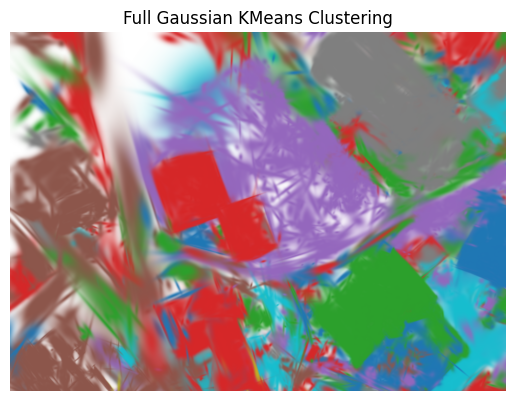

In [32]:
full_kmeans_seg = render(
    cameras[17],
    scene_gaussians,
    pipeline.extract(args),
    background,
    override_color=torch.from_numpy(point_colors).cuda().float()
)['render']

plt.imshow(full_kmeans_seg.permute(1, 2, 0).detach().cpu())
plt.title("Full Gaussian KMeans Clustering")
plt.axis("off")
plt.show()


In [33]:
#from languge driven segmentation
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        #sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.load(view.original_masks).cuda().unsqueeze(1)
        
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        #mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = torch.load(view.mask_scales).cuda().unsqueeze(-1)
        
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # N_scale N_anchor C
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        #scales.append(view.mask_scales.cuda().unsqueeze(-1))
        scales.append(torch.load(view.mask_scales).cuda().unsqueeze(-1))
        

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()
flattened_mask_features = torch.cat(seg_features, dim = 0)
#flattened_clip_features = torch.cat(clip_features, dim = 0)
clip_features = [torch.load(path).cuda() for path in clip_features]
flattened_clip_features = torch.cat(clip_features, dim=0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

10150


(torch.Size([225658, 32]),
 torch.Size([225658, 512]),
 torch.Size([225658, 1]),
 torch.Size([225658, 10150]),
 225658)

In [34]:
'''from sklearn.cluster import KMeans
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip

# === CONFIG ===
prompts = ["house", "apartment", "building", "villa","office"]
k = 15
clip_threshold = 0.2
camera_idx = 17
output_path = './segmentation_res/kmeans_combined_prompt_mask.pt'

# === Load CLIP model ===
clip_model = load_clip()
clip_model.eval()

# === Filter to valid features
id_mask = (flattened_mask_identifiers.sum(dim=1) > 0)
gaussian_indices = torch.nonzero(id_mask, as_tuple=False).squeeze(1)
clip_feats = torch.nn.functional.normalize(flattened_clip_features[id_mask], dim=-1)

# === KMeans clustering ===
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(clip_feats.cpu().numpy())
print(f"✅ KMeans formed {k} clusters.")

# === Multi-prompt CLIP scoring ===
with torch.no_grad():
    prompt_scores = [get_scores_with_template(clip_model, clip_feats.cuda(), p).squeeze(0).cpu() for p in prompts]
clip_scores = torch.stack(prompt_scores).max(dim=0)[0]  # best match per point

# === Select clusters with score > threshold ===
final_mask = torch.zeros_like(clip_scores, dtype=torch.bool)
print("\n📊 Cluster-wise avg CLIP score:")
for label in np.unique(cluster_labels):
    idx = (torch.tensor(cluster_labels) == label)
    avg_score = clip_scores[idx].mean().item()
    print(f"Cluster {label:2d} → avg score: {avg_score:.3f}")
    if avg_score > clip_threshold:
        final_mask[idx] = True

print(f"\n✅ Selected {final_mask.sum().item()} Gaussians across prompts.")

# === Expand back to full Gaussian size ===
full_mask = torch.zeros(scene.feature_gaussians.get_xyz.shape[0], dtype=torch.bool)
full_mask[gaussian_indices] = final_mask.squeeze()

# === Save mask ===
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(full_mask, output_path)

# === Render mask without modifying scene
point_colors = np.zeros((scene.feature_gaussians.get_xyz.shape[0], 3))
point_colors[full_mask.cpu().numpy()] = [1.0, 1.0, 1.0]  # white for selected

rendered = render(
    cameras[camera_idx],
    scene_gaussians,
    pipeline.extract(args),
    background,
    override_color=torch.from_numpy(point_colors).cuda().float()
)['render']

plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
plt.title("CLIP+KMeans (Multi-Prompt) Segmentation")
plt.axis("off")
plt.show()
'''

'from sklearn.cluster import KMeans\nimport torch\nimport numpy as np\nimport matplotlib.pyplot as plt\nimport os\nimport importlib\nimport clip_utils\nimportlib.reload(clip_utils)\nfrom clip_utils import get_scores_with_template\nfrom clip_utils.clip_utils import load_clip\n\n# === CONFIG ===\nprompts = ["house", "apartment", "building", "villa","office"]\nk = 15\nclip_threshold = 0.2\ncamera_idx = 17\noutput_path = \'./segmentation_res/kmeans_combined_prompt_mask.pt\'\n\n# === Load CLIP model ===\nclip_model = load_clip()\nclip_model.eval()\n\n# === Filter to valid features\nid_mask = (flattened_mask_identifiers.sum(dim=1) > 0)\ngaussian_indices = torch.nonzero(id_mask, as_tuple=False).squeeze(1)\nclip_feats = torch.nn.functional.normalize(flattened_clip_features[id_mask], dim=-1)\n\n# === KMeans clustering ===\nkmeans = KMeans(n_clusters=k, random_state=42)\ncluster_labels = kmeans.fit_predict(clip_feats.cpu().numpy())\nprint(f"✅ KMeans formed {k} clusters.")\n\n# === Multi-prompt C

Embedding dimension 512
✅ KMeans formed 30 clusters.

📊 Cluster-wise avg NOT-negative score:
Cluster  0 → avg 'not negative' score: 0.634
Cluster  1 → avg 'not negative' score: 0.549
Cluster  2 → avg 'not negative' score: 0.591
Cluster  3 → avg 'not negative' score: 0.514
Cluster  4 → avg 'not negative' score: 0.673
Cluster  5 → avg 'not negative' score: 0.523
Cluster  6 → avg 'not negative' score: 0.710
Cluster  7 → avg 'not negative' score: 0.547
Cluster  8 → avg 'not negative' score: 0.588
Cluster  9 → avg 'not negative' score: 0.709
Cluster 10 → avg 'not negative' score: 0.561
Cluster 11 → avg 'not negative' score: 0.566
Cluster 12 → avg 'not negative' score: 0.615
Cluster 13 → avg 'not negative' score: 0.622
Cluster 14 → avg 'not negative' score: 0.681
Cluster 15 → avg 'not negative' score: 0.567
Cluster 16 → avg 'not negative' score: 0.723
Cluster 17 → avg 'not negative' score: 0.609
Cluster 18 → avg 'not negative' score: 0.635
Cluster 19 → avg 'not negative' score: 0.686
Cluster

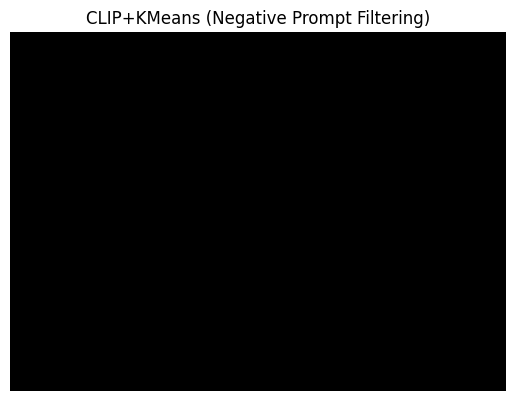

In [35]:
from sklearn.cluster import KMeans
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip

# === CONFIG ===
negative_prompts = ["road", "tree", "garden", "grass", "vegetation", "sidewalk","platform"]
k = 30
clip_threshold = 0.2  # Higher = stricter removal of negatives
camera_idx = 17
output_path = './segmentation_res/kmeans_negprompt_filtered_mask_0.8.pt'

# === Load CLIP model ===
clip_model = load_clip()
clip_model.eval()

# === Filter to valid CLIP features
id_mask = (flattened_mask_identifiers.sum(dim=1) > 0)
gaussian_indices = torch.nonzero(id_mask, as_tuple=False).squeeze(1)
clip_feats = torch.nn.functional.normalize(flattened_clip_features[id_mask], dim=-1)

# === KMeans clustering ===
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(clip_feats.cpu().numpy())
print(f"✅ KMeans formed {k} clusters.")

# === CLIP scoring using ONLY negative prompts
with torch.no_grad():
    neg_scores = [get_scores_with_template(clip_model, clip_feats.cuda(), p).squeeze(0).cpu() for p in negative_prompts]
neg_clip_scores = torch.stack(neg_scores).mean(dim=0)  # average negativity

# Invert to get relevance (1 = unlike road/tree/garden)
inverted_scores = 1.0 - neg_clip_scores

# === Select clusters whose inverted score > threshold (less like negatives)
final_mask = torch.zeros_like(inverted_scores, dtype=torch.bool)
print("\n📊 Cluster-wise avg NOT-negative score:")
for label in np.unique(cluster_labels):
    idx = (torch.tensor(cluster_labels) == label)
    avg_score = inverted_scores[idx].mean().item()
    print(f"Cluster {label:2d} → avg 'not negative' score: {avg_score:.3f}")
    if avg_score > clip_threshold:
        final_mask[idx] = True

print(f"\n✅ Selected {final_mask.sum().item()} Gaussians (not roads/gardens/trees)")

# === Expand to full Gaussian size
full_mask = torch.zeros(scene.feature_gaussians.get_xyz.shape[0], dtype=torch.bool)
full_mask[gaussian_indices] = final_mask.squeeze()

# === Save final mask
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(full_mask, output_path)

# === Render
point_colors = np.zeros((scene.feature_gaussians.get_xyz.shape[0], 3))
point_colors[full_mask.cpu().numpy()] = [1.0, 1.0, 1.0]

rendered = render(
    cameras[camera_idx],
    scene_gaussians,
    pipeline.extract(args),
    background,
    override_color=torch.from_numpy(point_colors).cuda().float()
)['render']

plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
plt.title("CLIP+KMeans (Negative Prompt Filtering)")
plt.axis("off")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip

# === CONFIG ===
prompt_text = "house"
clip_threshold = 0.3
k = 30
camera_idx = 17
output_path = './segmentation_res/kmeans_clip_individual_threshold.pt'

# === Load CLIP model ===
clip_model = load_clip()
clip_model.eval()

# === Filter to valid Gaussians
id_mask = (flattened_mask_identifiers.sum(dim=1) > 0)
gaussian_indices = torch.nonzero(id_mask, as_tuple=False).squeeze(1)
clip_feats = torch.nn.functional.normalize(flattened_clip_features[id_mask], dim=-1)

# === (Optional) Add position info
xyz = scene.feature_gaussians.get_xyz[gaussian_indices]
scaled_xyz = 0.3 * xyz  # Tune if needed
combined_feats = torch.cat([clip_feats, scaled_xyz], dim=1)

# === Run KMeans for future use (optional visualization)
kmeans = KMeans(n_clusters=k, random_state=42)
_ = kmeans.fit_predict(combined_feats.detach().cpu().numpy())
print(f"✅ KMeans run completed with k = {k}")

# === Per-point CLIP score filtering (main segmentation logic)
with torch.no_grad():
    scores = get_scores_with_template(clip_model, clip_feats.cuda(), prompt_text)
clip_scores = scores.squeeze(0).cpu()  # shape [N]

final_mask = clip_scores > clip_threshold
print(f"\n✅ Selected {final_mask.sum().item()} Gaussians with '{prompt_text}' > {clip_threshold:.2f}")

# === Expand back to full Gaussian size
full_mask = torch.zeros(scene.feature_gaussians.get_xyz.shape[0], dtype=torch.bool)
full_mask[gaussian_indices] = final_mask.squeeze()

# === Save mask
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(full_mask, output_path)

# === Visualize
point_colors = np.zeros((scene.feature_gaussians.get_xyz.shape[0], 3))
point_colors[full_mask.cpu().numpy()] = [1.0, 1.0, 1.0]  # white

rendered = render(
    cameras[camera_idx],
    scene_gaussians,
    pipeline.extract(args),
    background,
    override_color=torch.from_numpy(point_colors).cuda().float()
)['render']

plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
plt.title(f"CLIP Threshold Only ('{prompt_text}')")
plt.axis("off")
plt.show()


In [ ]:
from sklearn.cluster import KMeans
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip

# === CONFIG ===
prompt_text = "house"
clip_threshold = 0.3
k = 30
min_cluster_size = 10000
num_refine_clusters = 3
camera_idx = 17
output_path = './segmentation_res/kmeans_clip_refined.pt'

# === Load CLIP model ===
clip_model = load_clip()
clip_model.eval()

# === Filter to valid CLIP features
id_mask = (flattened_mask_identifiers.sum(dim=1) > 0)
gaussian_indices = torch.nonzero(id_mask, as_tuple=False).squeeze(1)
clip_feats = torch.nn.functional.normalize(flattened_clip_features[id_mask], dim=-1)
xyz = scene.feature_gaussians.get_xyz[gaussian_indices]
combined_feats = torch.cat([clip_feats, 0.3 * xyz], dim=1)

# === Run KMeans
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_labels = kmeans.fit_predict(combined_feats.cpu().detach().numpy())

# === CLIP scoring per cluster
final_mask = torch.zeros(len(cluster_labels), dtype=torch.bool)
with torch.no_grad():
    for cid in np.unique(cluster_labels):
        idx = (torch.tensor(cluster_labels) == cid)
        cluster_clip_feats = clip_feats[idx]

        if idx.sum() < min_cluster_size:
            score = get_scores_with_template(clip_model, cluster_clip_feats.cuda(), prompt_text).squeeze().cpu()
            if score.mean().item() > clip_threshold:
                final_mask[idx] = True
        else:
            sub_kmeans = KMeans(n_clusters=num_refine_clusters, random_state=42)
            sub_labels = sub_kmeans.fit_predict(cluster_clip_feats.cpu().numpy())
            scores = get_scores_with_template(clip_model, cluster_clip_feats.cuda(), prompt_text).squeeze().cpu()
            for sid in range(num_refine_clusters):
                sub_idx = (torch.tensor(sub_labels) == sid)
                if scores[sub_idx].mean().item() > clip_threshold:
                    final_mask[idx.nonzero(as_tuple=True)[0][sub_idx]] = True

# === Expand to full scene
full_mask = torch.zeros(scene.feature_gaussians.get_xyz.shape[0], dtype=torch.bool)
full_mask[gaussian_indices] = final_mask

# === Save mask
os.makedirs('./segmentation_res', exist_ok=True)
torch.save(full_mask, output_path)

# === Visualization
point_colors = np.zeros((scene.feature_gaussians.get_xyz.shape[0], 3))
point_colors[full_mask.cpu().numpy()] = [1.0, 1.0, 1.0]

for i, cam in enumerate(cameras):
    rendered = render(
        cam,
        scene_gaussians,
        pipeline.extract(args),
        background,
        override_color=torch.from_numpy(point_colors).cuda().float()
    )['render']
    plt.imshow(rendered.permute(1, 2, 0).detach().cpu())
    plt.title(f"Refined CLIP+KMeans – Camera {i}")
    plt.axis("off")
    plt.show()


In [33]:
seg_score = torch.einsum('nc,bc->bn', cluster_centers.cpu(), normed_point_features.cpu())

In [34]:
#label_to_color = np.random.rand(1000, 3)
#point_colors = label_to_color[seg_score.argmax(dim = -1).cpu().numpy()]
#point_colors[seg_score.max(dim = -1)[0].detach().cpu().numpy() < 0.15] = (0,0,0)

In [43]:
import torch
import numpy as np
from collections import Counter
from sklearn.neighbors import NearestNeighbors

def adaptive_segmentation_v2(
    cluster_labels,
    clip_scores,
    point_xyz=None,
    percentile_thresh=(50, 80),
    clip_thresholds=(0.22, 0.18, 0.13),
    knn_smoothing=True,
    knn_k=12,
    min_fraction_pass=0.5
):
    """
    Full adaptive segmentation with CLIP score filtering, percentile-based thresholds,
    and optional kNN smoothing.

    Args:
        cluster_labels (Tensor or np.ndarray): Cluster assignments [N]
        clip_scores (Tensor): CLIP similarity scores [N]
        point_xyz (Tensor, optional): 3D positions [N, 3] (required for kNN smoothing)
        percentile_thresh (tuple): Percentiles for cluster size buckets
        clip_thresholds (tuple): Thresholds for (small, mid, large) clusters
        knn_smoothing (bool): Whether to apply majority-vote kNN label smoothing
        knn_k (int): Number of neighbors for smoothing
        min_fraction_pass (float): Minimum fraction of cluster points above threshold to keep cluster

    Returns:
        final_mask (BoolTensor): Points to keep
    """
    if isinstance(cluster_labels, torch.Tensor):
        cluster_labels = cluster_labels.cpu().numpy()

    scores = clip_scores.detach().cpu()
    sizes = Counter(cluster_labels)
    thresholds = {}

    size_vals = np.array(list(sizes.values()))
    q1, q2 = np.percentile(size_vals, percentile_thresh)

    def get_thresh(size):
        if size < q1:
            return clip_thresholds[0]
        elif size < q2:
            return clip_thresholds[1]
        else:
            return clip_thresholds[2]

    final_mask = torch.zeros_like(scores, dtype=torch.bool)

    for cid in np.unique(cluster_labels):
        if cid == -1:
            continue
        mask = (cluster_labels == cid)
        size = sizes[cid]
        thresh = get_thresh(size)
        thresholds[cid] = thresh

        passed = (scores[mask] > thresh)
        fraction = passed.sum().item() / mask.sum()

        if fraction > min_fraction_pass:
            final_mask[mask] = passed

    print("\n📊 Adaptive Thresholds Used:")
    for cid, t in thresholds.items():
        print(f"  Cluster {cid:2d} → Size: {sizes[cid]:5d}, Threshold: {t:.2f}")

    if knn_smoothing and point_xyz is not None:
        print("\n🔄 Applying kNN smoothing...")
        xyz_np = point_xyz.detach().cpu().numpy()
        labels = final_mask.int()
        nn = NearestNeighbors(n_neighbors=knn_k).fit(xyz_np)
        _, indices = nn.kneighbors(xyz_np)
        smooth_mask = torch.zeros_like(final_mask)
        for i in range(len(labels)):
            neighbors = labels[indices[i]]
            smooth_mask[i] = torch.mode(neighbors).values
        final_mask = smooth_mask.bool()

    return final_mask


In [44]:
# Step 1: Get cluster labels per point
labels = seg_score.argmax(dim=-1).cpu()  # shape [N]
scores = seg_score.max(dim=-1)[0].cpu()  # shape [N]

# Step 2: Run adaptive thresholding
final_mask = adaptive_segmentation_v2(
    cluster_labels=seg_score.argmax(dim=-1),
    clip_scores=seg_score.max(dim=-1)[0],
    point_xyz=scene_gaussians.get_xyz,  # if available
    percentile_thresh=(50, 80),
    clip_thresholds=(0.25, 0.20, 0.15),
    knn_smoothing=True,
    knn_k=12,
    min_fraction_pass=0.5
)

scene_gaussians.segment(final_mask)
torch.save(final_mask, './segmentation_res/adaptive_thresholding_knn_12.pt')
# Step 3: Assign colors (only for selected points)
labels_np = labels.numpy()
label_to_color = np.random.rand(1000, 3)
point_colors = np.zeros((len(labels_np), 3))
for i in range(len(labels_np)):
    if final_mask[i]:
        point_colors[i] = label_to_color[labels_np[i]]
    else:
        point_colors[i] = (0, 0, 0)  # background



📊 Adaptive Thresholds Used:
  Cluster  1 → Size: 10794, Threshold: 0.25
  Cluster  2 → Size: 19185, Threshold: 0.20
  Cluster  3 → Size:  9378, Threshold: 0.25
  Cluster  4 → Size:  4788, Threshold: 0.25
  Cluster  5 → Size: 14805, Threshold: 0.20
  Cluster  6 → Size: 11445, Threshold: 0.25
  Cluster  7 → Size: 24109, Threshold: 0.20
  Cluster  8 → Size: 12626, Threshold: 0.25
  Cluster  9 → Size: 11928, Threshold: 0.25
  Cluster 10 → Size: 37848, Threshold: 0.15
  Cluster 11 → Size: 10183, Threshold: 0.25
  Cluster 12 → Size:  8362, Threshold: 0.25
  Cluster 13 → Size:  4509, Threshold: 0.25
  Cluster 14 → Size: 35269, Threshold: 0.15
  Cluster 15 → Size: 43204, Threshold: 0.15
  Cluster 16 → Size: 30268, Threshold: 0.15
  Cluster 17 → Size: 40041, Threshold: 0.15
  Cluster 18 → Size: 22260, Threshold: 0.20
  Cluster 19 → Size:  3880, Threshold: 0.25
  Cluster 20 → Size: 13859, Threshold: 0.20
  Cluster 21 → Size: 33073, Threshold: 0.15
  Cluster 22 → Size:  5987, Threshold: 0.25
  C

In [45]:
from collections import Counter
import numpy as np

# seg_score: [num_points, num_clusters]
predicted_labels = seg_score.argmax(dim=-1).cpu().numpy()

# Final mask after thresholding (BoolTensor)
final_mask_np = final_mask.cpu().numpy()

# Total points per cluster (before thresholding)
cluster_counts_total = Counter(predicted_labels)

# Points per cluster that passed CLIP threshold
cluster_counts_kept = Counter(predicted_labels[final_mask_np])

print("\n📊 Final Cluster Coverage (on full point cloud):")
for cluster_id in sorted(cluster_counts_total.keys()):
    total = cluster_counts_total[cluster_id]
    kept = cluster_counts_kept.get(cluster_id, 0)
    print(f"  Cluster {cluster_id:2d} → Total: {total:5d}, Kept after threshold: {kept:5d}, Kept %: {kept / total:.2%}")



📊 Final Cluster Coverage (on full point cloud):
  Cluster  1 → Total: 10794, Kept after threshold: 10794, Kept %: 100.00%
  Cluster  2 → Total: 19185, Kept after threshold: 19185, Kept %: 100.00%
  Cluster  3 → Total:  9378, Kept after threshold:  9378, Kept %: 100.00%
  Cluster  4 → Total:  4788, Kept after threshold:  4788, Kept %: 100.00%
  Cluster  5 → Total: 14805, Kept after threshold: 14805, Kept %: 100.00%
  Cluster  6 → Total: 11445, Kept after threshold: 11445, Kept %: 100.00%
  Cluster  7 → Total: 24109, Kept after threshold: 24109, Kept %: 100.00%
  Cluster  8 → Total: 12626, Kept after threshold: 12626, Kept %: 100.00%
  Cluster  9 → Total: 11928, Kept after threshold: 11928, Kept %: 100.00%
  Cluster 10 → Total: 37848, Kept after threshold: 37848, Kept %: 100.00%
  Cluster 11 → Total: 10183, Kept after threshold: 10183, Kept %: 100.00%
  Cluster 12 → Total:  8362, Kept after threshold:  8362, Kept %: 100.00%
  Cluster 13 → Total:  4509, Kept after threshold:  4509, Kept 

In [46]:
try:
    scene_gaussians.roll_back()
except:
    pass

In [47]:
bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")


rendered_seg_map = render(cameras[17], scene_gaussians, pipeline.extract(args), background, override_color=torch.from_numpy(point_colors).cuda().float())['render']

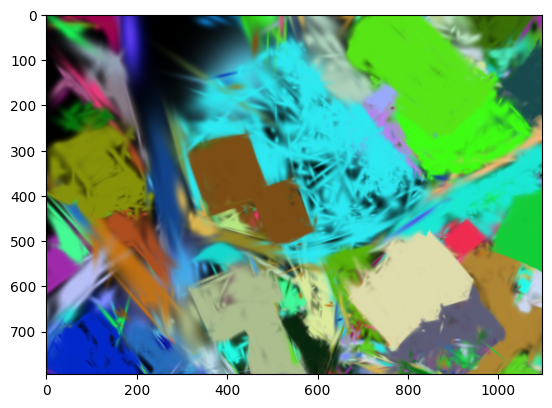

In [48]:
plt.imshow(rendered_seg_map.permute([1,2,0]).detach().cpu().numpy())

In [49]:
from collections import Counter
print(Counter(cluster_labels))

Counter({23: 54795, 6: 48899, 7: 46772, 10: 45365, 1: 44920, 2: 43991, 24: 43712, 22: 41420, 28: 41103, 4: 40163, 8: 39995, 25: 39567, 5: 39225, 20: 38562, 21: 37143, 14: 37003, 13: 36345, 29: 35757, 27: 32581, 11: 30210, 9: 29646, 16: 29277, 12: 27629, 19: 27296, 17: 19320, 26: 16877, 3: 16785, 15: 12079, 0: 8402, 18: 2893})


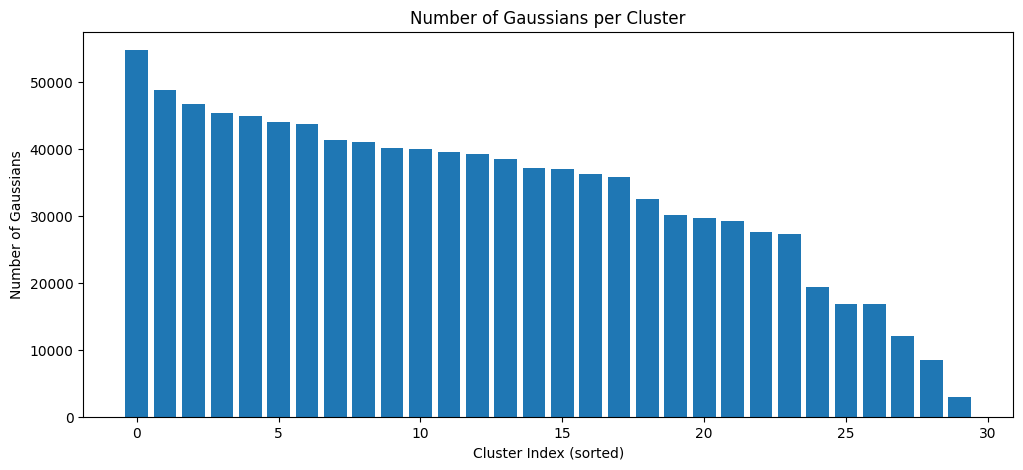

In [50]:
import matplotlib.pyplot as plt
import numpy as np

# Count how many points are in each cluster
labels = cluster_labels  # already computed from HDBSCAN
unique_labels, counts = np.unique(labels, return_counts=True)

# Skip noise (-1), if needed
valid = unique_labels != -1
unique_labels = unique_labels[valid]
counts = counts[valid]

# Sort by size (optional)
sorted_indices = np.argsort(-counts)
sorted_labels = unique_labels[sorted_indices]
sorted_counts = counts[sorted_indices]

# Plot
plt.figure(figsize=(12,5))
plt.bar(range(len(sorted_counts)), sorted_counts)
plt.xlabel("Cluster Index (sorted)")
plt.ylabel("Number of Gaussians")
plt.title("Number of Gaussians per Cluster")
plt.show()


# Clip features with 3d cluster #My changes

In [50]:
from collections import Counter
print(Counter(cluster_labels))

Counter({23: 54799, 6: 48896, 7: 46768, 10: 45368, 1: 44922, 2: 43998, 24: 43710, 22: 41422, 28: 41102, 4: 40161, 8: 39992, 25: 39560, 5: 39228, 20: 38566, 21: 37133, 14: 37003, 13: 36347, 29: 35752, 27: 32593, 11: 30208, 9: 29643, 16: 29277, 12: 27629, 19: 27296, 17: 19322, 26: 16878, 3: 16785, 15: 12079, 0: 8402, 18: 2893})


In [51]:
unique_labels = torch.unique(seg_score.argmax(dim=-1))  # [num_clusters]
normed_point_features = torch.nn.functional.normalize(feature_gaussians.get_point_features, dim=-1, p=2)

cluster_features = []
for label in unique_labels:
    mask = (seg_score.argmax(dim=-1) == label)
    cluster_feat = normed_point_features[mask].mean(dim=0)
    cluster_feat = torch.nn.functional.normalize(cluster_feat, dim=0, p=2)
    cluster_features.append(cluster_feat)

cluster_features = torch.stack(cluster_features).cuda()  # [num_clusters, F]


In [52]:
import clip
import torch

def load_clip():
    model, _ = clip.load("ViT-B/32", device="cuda")
    return model

def encode_text(model, text):
    tokens = clip.tokenize([text]).cuda()
    with torch.no_grad():
        return model.encode_text(tokens).squeeze(0)

# Load CLIP
clip_model = load_clip().eval()

# Positive prompts
positive_prompts = ["house", "home", "residential building", "villa", "apartment", "building"]
positive_feats = [encode_text(clip_model, p).float() for p in positive_prompts]
positive_feat = torch.stack(positive_feats).mean(dim=0)

# Negative prompts
negative_prompts = ["roads","plants"]
negative_feats = [encode_text(clip_model, p).float() for p in negative_prompts]
negative_feat = torch.stack(negative_feats).mean(dim=0)

# Normalize both
positive_feat = torch.nn.functional.normalize(positive_feat, dim=0, p=2)
negative_feat = torch.nn.functional.normalize(negative_feat, dim=0, p=2)

# Final composite feature
#text_feat = torch.nn.functional.normalize(positive_feat - 0.5 * negative_feat, dim=0, p=2)
text_feat = torch.nn.functional.normalize(-negative_feat, dim=0, p=2)


In [53]:
projection = torch.nn.Linear(512, 32).cuda()
text_feat_projected = projection(text_feat.float().unsqueeze(0)).squeeze(0)
text_feat_projected = torch.nn.functional.normalize(text_feat_projected, dim=0, p=2)

clip_scores = torch.einsum('cf,f->c', cluster_features, text_feat_projected)

top_k = 5  # or adjust based on how many clusters you want
topk_indices = torch.topk(clip_scores, k=top_k).indices
print("Top matching cluster indices:", topk_indices)

selected_mask = torch.zeros_like(seg_score.argmax(dim=-1), dtype=torch.bool)
for idx in topk_indices:
    selected_mask |= (seg_score.argmax(dim=-1) == unique_labels[idx])



Top matching cluster indices: tensor([ 7, 55, 54, 37, 29], device='cuda:0')


In [54]:
#selected_mask = (seg_score.argmax(dim=-1) == best_label)
scene_gaussians.segment(selected_mask)
torch.save(selected_mask, './segmentation_res/clip_guided_cluster_segment.pt')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.00010014033..1.8966953].


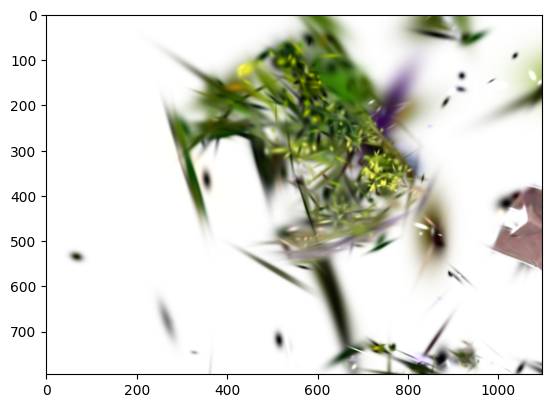

In [55]:
bg_color = [1 for _ in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered.permute(1, 2, 0).detach().cpu())


# Clean segmentation

In [ ]:
import torch
from sklearn.neighbors import NearestNeighbors
from collections import Counter

def clean_segmentation(points, labels, scores=None, min_cluster_size=100, knn_k=10, score_thresh=0.2):
    import torch
    from collections import Counter
    from sklearn.neighbors import NearestNeighbors

    # Ensure labels are torch tensors
    if not isinstance(labels, torch.Tensor):
        labels = torch.tensor(labels)

    # Ensure scores are torch tensors
    if scores is not None and not isinstance(scores, torch.Tensor):
        scores = torch.tensor(scores)

    # Ensure points are detached numpy
    if isinstance(points, torch.Tensor):
        points = points.detach().cpu().numpy()

    device = scores.device if scores is not None else torch.device("cpu")
    labels = seg_score.argmax(dim=-1)
    labels = labels.to(device).clone().detach()


    # Step 1: Remove small clusters
    label_counts = Counter(labels.cpu().numpy())
    keep_labels = [lbl for lbl, count in label_counts.items() if count >= min_cluster_size]
    keep_mask = torch.isin(labels, torch.tensor(keep_labels, device=device))
    labels[~keep_mask] = -1  # mark small clusters as background

    # Step 2: Smooth labels using k-NN majority vote
    if isinstance(points, torch.Tensor):
        points = points.cpu().numpy()
    nbrs = NearestNeighbors(n_neighbors=knn_k).fit(points)
    _, indices = nbrs.kneighbors(points)
    smoothed_labels = torch.empty_like(labels)

    for i in range(len(labels)):
        neighbor_labels = labels[indices[i]]
        valid = neighbor_labels[neighbor_labels != -1]
        if len(valid) == 0:
            smoothed_labels[i] = -1
        else:
            smoothed_labels[i] = torch.mode(valid)[0]

    # Step 3: Score-based filtering (optional)
    cleaned_mask = smoothed_labels != -1
    if scores is not None:
        cleaned_mask &= scores > score_thresh

    return cleaned_mask


In [ ]:
# Inputs
points = scene.feature_gaussians.get_xyz.cpu()  # Nx3
labels = cluster_labels  # from HDBSCAN or seg_score.argmax
scores = seg_score.max(dim=-1)[0].cpu()  # optional

# Clean up
cleaned_mask = clean_segmentation(points, labels, scores=scores)

# Apply
scene_gaussians.segment(cleaned_mask)
torch.save(cleaned_mask, './segmentation_res/cleaned_mask.pt')


# Language-driven Segmentation

In [ ]:
# sample some anchor points in 3D
anchor_point_features = feature_gaussians.get_point_features[torch.rand(feature_gaussians.get_point_features.shape[0]) > 0.99]
print(len(anchor_point_features))

In [ ]:
from copy import deepcopy

seg_features = []
clip_features = []
scales = []
mask_identifiers = []
camera_id_mask_id = []

# vote_weights = []

bg_color = [0 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")

i=0
for view in scene.getTrainCameras():
    torch.cuda.empty_cache()
    clip_features.append(view.original_features)
    tmp_view = deepcopy(view)
    tmp_view.feature_height, tmp_view.feature_width = view.original_image.shape[-2:]

    rendered_feature = render_contrastive_feature(tmp_view, feature_gaussians, pipeline.extract(args), background, norm_point_features=True)['render']
    feature_h, feature_w = rendered_feature.shape[-2:]

    with torch.no_grad():
        # NOTE: 3D-OVS need 8x downsample since its images are in 4K resolution
        # rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 8, feature_w // 8), mode = 'bilinear').squeeze()
        # sam_masks = view.original_masks.cuda().unsqueeze(1)
        # sam_masks = torch.nn.functional.interpolate(sam_masks, (feature_h // 8, feature_w // 8), mode = 'bilinear')

        rendered_feature = torch.nn.functional.interpolate(rendered_feature.unsqueeze(0), (feature_h // 4, feature_w // 4), mode = 'bilinear').squeeze()
        #sam_masks = view.original_masks.cuda().unsqueeze(1)
        sam_masks = torch.load(view.original_masks).cuda().unsqueeze(1)
        
        sam_masks = torch.nn.functional.interpolate(sam_masks.float(), (feature_h // 4, feature_w // 4), mode = 'bilinear')


        sam_masks = torch.conv2d(
            sam_masks.float().cpu(),
            torch.full((3, 3), 1.0).view(1, 1, 3, 3).cpu(),
            padding=1,
        )
        sam_masks = sam_masks >= 2
        sam_masks = sam_masks.cuda()


        # vote_weights is the number of pixels in the mask
        # vote_weights.append(sam_masks.sum(dim = -1).sum(dim = -1))

        # sam_masks = torch.nn.functional.interpolate(sam_masks.unsqueeze(1), (view.feature_height, view.feature_width), mode = 'bilinear')
        # sam_masks[sam_masks > 0.75] = 1
        # sam_masks[sam_masks != 1] = 0

        #mask_scales = view.mask_scales.cuda().unsqueeze(-1)
        mask_scales = torch.load(view.mask_scales).cuda().unsqueeze(-1)
        
        mask_scales = q_trans(mask_scales)

        scale_gates = scale_gate(mask_scales)
        
        # int_sampled_scales = ((1 - mask_scales.squeeze()) * 10).long()
        # scale_gates = fixed_scale_gate[int_sampled_scales].detach()

        # N_scale N_anchor C
        # scale_conditioned_anchor_point_features = torch.einsum('nc,mc->nmc',scale_gates, anchor_point_features)
        scale_conditioned_anchor_point_features = scale_gates.unsqueeze(1) * anchor_point_features.unsqueeze(0)
        scale_conditioned_anchor_point_features = torch.nn.functional.normalize(scale_conditioned_anchor_point_features, dim = -1, p = 2)

        # N_scale C H W
        scale_conditioned_feature = rendered_feature.unsqueeze(0) * scale_gates.unsqueeze(-1).unsqueeze(-1)
        scale_conditioned_feature = torch.nn.functional.normalize(scale_conditioned_feature, dim = 1, p = 2)

        # N_scale C
        mask_features = (sam_masks * scale_conditioned_feature).sum(dim = -1).sum(dim = -1) / (sam_masks.sum(dim = -1).sum(dim = -1) + 1e-9)
        mask_features = torch.nn.functional.normalize(mask_features, dim = -1, p = 2)

        mask_identifier = torch.einsum('nmc,nc->nm', scale_conditioned_anchor_point_features, mask_features) > 0.5
        
        mask_identifiers.append(mask_identifier.cpu())
        seg_features.append(mask_features)
        #scales.append(view.mask_scales.cuda().unsqueeze(-1))
        scales.append(torch.load(view.mask_scales).cuda().unsqueeze(-1))
        

        for j in range(len(mask_features)):
            camera_id_mask_id.append((i, j))
        i+=1
torch.cuda.empty_cache()

In [ ]:
flattened_mask_features = torch.cat(seg_features, dim = 0)
#flattened_clip_features = torch.cat(clip_features, dim = 0)
clip_features = [torch.load(path).cuda() for path in clip_features]
flattened_clip_features = torch.cat(clip_features, dim=0)
flattened_clip_features = torch.nn.functional.normalize(flattened_clip_features.float(), dim = -1, p = 2)
flattened_scales = torch.cat(scales, dim = 0)
flattened_mask_identifiers = torch.cat(mask_identifiers, dim = 0).to(torch.float16).cuda()
flattened_mask_features.shape, flattened_clip_features.shape, flattened_scales.shape, flattened_mask_identifiers.shape, len(camera_id_mask_id)

In [ ]:
import umap
from hdbscan import HDBSCAN
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import torch

# Step 1: Optional PCA to 64D
features = flattened_clip_features.cpu().numpy()
features = PCA(n_components=64).fit_transform(features)

# Step 2: UMAP to 2D (for visualization) and 32D (for clustering)
print("🔄 Running UMAP...")
reducer_for_clustering = umap.UMAP(n_components=32, metric='cosine', n_neighbors=50, min_dist=0.3, random_state=42)
features_umap_32d = reducer_for_clustering.fit_transform(features)

# For 2D visualization
reducer_for_plot = umap.UMAP(n_components=2, metric='cosine', n_neighbors=50, min_dist=0.3, random_state=42)
features_umap_2d = reducer_for_plot.fit_transform(features)

# Step 3: HDBSCAN
print("🔍 Clustering with HDBSCAN (min_cluster_size=50, min_samples=10)...")
#clusterer = HDBSCAN(min_cluster_size=50, min_samples=10, metric='cosine', algorithm='generic')
clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(features_umap_32d)
print('to torch')
# Step 4: To torch
cluster_labels = torch.from_numpy(cluster_labels).to(flattened_clip_features.device)
n_clusters = len(torch.unique(cluster_labels[cluster_labels != -1]))
print(f"✅ Found {n_clusters} clusters (excluding noise)")

# Step 5: Visualize
plt.figure(figsize=(10, 8))
palette = plt.get_cmap("tab20")
for label in set(cluster_labels.cpu().numpy()):
    mask = cluster_labels.cpu().numpy() == label
    plt.scatter(features_umap_2d[mask, 0], features_umap_2d[mask, 1], 
                s=10, label=f"Cluster {label}" if label != -1 else "Noise", 
                alpha=0.6, c=[palette(label % 20)] * mask.sum())
plt.title(f"UMAP + HDBSCAN Segmentation View ({n_clusters} clusters)")
plt.legend(loc='best', markerscale=2, fontsize=8)
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
view = scene.getTrainCameras()[0]
vmask=torch.load(view.original_masks)
print("original_masks shape:", vmask.shape)

In [ ]:
# Choose the cluster to visualize (e.g., Cluster 2)
target_cluster_id = 1

# Get indices of masks belonging to this cluster
cluster_indices = (cluster_labels == target_cluster_id).nonzero(as_tuple=True)[0]

print(f"Cluster {target_cluster_id} has {len(cluster_indices)} masks.")

# Visualize first 5 masks
import matplotlib.pyplot as plt

num_to_show = 5  # adjust based on how many masks you want
for i, idx in enumerate(cluster_indices[:num_to_show]):
    cam_id, mask_id = camera_id_mask_id[idx]

    # Load the mask tensor
    view = scene.getTrainCameras()[cam_id]
    vmask = torch.load(view.original_masks).cpu()

    plt.subplot(1, num_to_show, i + 1)
    plt.imshow(vmask[mask_id], cmap='gray')
    plt.title(f"Cam {cam_id}, Mask {mask_id}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [ ]:
'''# Construct vote graph

from hdbscan import HDBSCAN

clusterer = HDBSCAN(min_cluster_size=30, cluster_selection_epsilon=0.25, metric='precomputed')
cluster_labels = clusterer.fit_predict(distance_map.detach().cpu().numpy().astype(np.float64))
cluster_labels = torch.from_numpy(cluster_labels).to(device = flattened_clip_features.device, dtype = torch.long)'''

In [ ]:
import importlib
import clip_utils
importlib.reload(clip_utils)
from clip_utils import get_scores_with_template
from clip_utils.clip_utils import load_clip
clip_model = load_clip()
clip_model.eval()
1

In [ ]:
# Convert input text prompts to scores for multi-view masks

scores = get_scores_with_template(clip_model, flattened_clip_features.cuda(), "house")
scores = scores.squeeze()

In [ ]:
cluster_scores = torch.zeros(len(torch.unique(cluster_labels)), device=cluster_labels.device)
for cluster_idx in torch.unique(cluster_labels):
    cluster_scores[cluster_idx] = scores[cluster_labels == cluster_idx].mean()
for i, score in enumerate(cluster_scores):
    print(f"Cluster {i}: Score = {score.item():.4f}")


In [ ]:
cluster_id = 1
target_camera_id = 85

indices = (cluster_labels == cluster_id).nonzero(as_tuple=True)[0]

count = 0  # Just to limit number of masks if needed
for i in indices:
    cam_id, mask_id = camera_id_mask_id[i]
    if cam_id == target_camera_id:
        mask = torch.load(scene.getTrainCameras()[cam_id].original_masks)[mask_id].cpu().numpy()
        plt.imshow(mask)
        plt.title(f"Mask {mask_id} from Camera {cam_id}")
        plt.show()

        count += 1
        if count >= 10:  # Show up to 10 masks
            break


In [ ]:
def cluster_id_to_scales(cluster_labels, flattened_scales, cluster_idx, scores):
    max_score_mask_scale_id = scores[cluster_labels == cluster_idx].argmax()
    return flattened_scales[cluster_labels == cluster_idx][max_score_mask_scale_id].item(), max_score_mask_scale_id

cluster_labels.unique(), cluster_labels.unique()[cluster_scores.argmax()], cluster_scores.max()

In [ ]:
good_clusters = torch.where(cluster_scores > 0.45)[0]
good_cluster_scores = cluster_scores[good_clusters]
if len(good_clusters) != 0:
    print(len(good_clusters))
    good_clusters = [cluster_labels.unique()[i] for i in good_clusters]
else:
    good_clusters = [cluster_labels.unique()[cluster_scores.argmax()]]

clip_query_features = []
corresponding_scales = []

for g in good_clusters:

    s, ind = cluster_id_to_scales(cluster_labels, flattened_scales, g, scores)
    clip_query_features.append(torch.nn.functional.normalize(flattened_mask_features[cluster_labels == g][ind], dim = -1, p = 2))

    corresponding_scales.append(s)

In [ ]:
from typing import Callable
def get_similarity_map(point_features:torch.Tensor, scale:float, scale_gate:Callable, clip_query_feature:torch.Tensor, q_trans:Callable[[torch.Tensor], torch.Tensor]):
    # scale = 0.5
    scale = torch.full((1,), scale).cuda()
    scale = q_trans(scale)

    gates = scale_gate(scale).detach().squeeze()

    print(point_features.shape, gates.shape)

    scale_conditioned_point_features = point_features * gates.unsqueeze(0)

    normed_scale_conditioned_point_features = torch.nn.functional.normalize(scale_conditioned_point_features, dim = -1, p = 2)

    similarities = torch.einsum('C,NC->N', clip_query_feature, normed_scale_conditioned_point_features)

    return similarities


In [ ]:
index = 0
similarities = get_similarity_map(feature_gaussians.get_point_features, corresponding_scales[index], scale_gate, clip_query_features[index], q_trans)
good_cluster_scores

In [ ]:
print("Min:", similarities.min().item())
print("Max:", similarities.max().item())
print("Non-zero count:", (similarities > 0).sum().item(), "out of", similarities.numel())


In [ ]:
'''threshold = 0.65
selected_mask = similarities > threshold
feature_gaussians.segment(similarities > threshold)'''


In [ ]:
import matplotlib.pyplot as plt
plt.hist(similarities.detach().cpu().numpy(), bins=100)
plt.title("Similarity Score Distribution")
plt.show()

In [ ]:
try:
    scene_gaussians.roll_back()
except:
    pass
selected_mask = similarities > 0.2 #0.3 not clear

scene_gaussians.segment(selected_mask)
print("Selected points:", selected_mask.sum().item(), "of", similarities.numel())

print("Selected points:", (similarities > 0.15).sum().item(), "/", similarities.shape[0])
torch.save(selected_mask.cpu(), "./segmentation_res/language_driven_house_mask.pt")


In [ ]:
print("Using cluster:", good_clusters[0])
print("Scale selected:", corresponding_scales[0])

bg_color = [1 for i in range(FEATURE_DIM)]
background = torch.tensor(bg_color, dtype=torch.float32, device="cuda")
rendered_segmented_image = render(cameras[17], scene_gaussians, pipeline.extract(args), background)['render']
plt.imshow(rendered_segmented_image.permute([1,2,0]).detach().cpu())
